## Goal
We are trying to create a genre classifier with an accuracy of at least 75% for Blues, Country, Electronic, Folk, Jazz, Latin, Rap, and Rock music. 


## Approaches
- Create tensors with music data from .h5 files in our assembled dataset. Then, we can train an image classifier on them, with the genre of each tensor as the ground truth label.
- If the approach outlined above doesn't work (This may be the case if samples from different genres are not different enough from each other), get access to the audio clips corresponding to each sample. Here, we have two options:
    1. run image classification on tensors made from the audio.
    2. Analyze the audio using the librosa python library to produce more features in addition to the one provided by the MSD. Then, we could go through the first outlined approach, but with more features for each sample. 

If our assembled dataset doesn't have enough samples for one or more genres, we could try using our Google Cloud credits to download the entire MSD, and repeat our data assembling process on that. 

## Important Data Features
(Taken from h5 fields)
- segment timbre
- time signature
- tempo
- similar artists
- get_artist_id (If we find a matching artist for this or similar artists we could potentially rule out certain genres or weigh more heavily to some genres)
- loudness
- key
- energy
- artist_terms (Haven't looked too much into this but it might be helpful for grabbing some info about what the artist is like and what genres of music they make)

## Options for ML Models
- VGG-19
- ResNet




In [ ]:
#imports
import os

import torch, torchvision

from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.autograd import Variable

import numpy as np

# For getting dataset from google drive
!pip install googledrivedownloader

### The Model

In [ ]:
# downloading pretrained vgg19 model
base_model_vgg = models.vgg19(pretrained=True)
base_model_vgg

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# accessing the last layers of the vgg19 base model
base_model_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# changing the last layer of the the vgg19 base model to have 8 output features instead of 1000
base_model_vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5, inplace=False), 
    nn.Linear(in_features=4096, out_features=4096, bias=True), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5, inplace=False), 
    nn.Linear(in_features=4096, out_features=8, bias=True)
)
model = base_model_vgg
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)

In [ ]:
# accessing the first layer of the vgg19-based model
list(model.children())[0][0] # it has 3 input channels, but we only need 1.

# 1, 6, 3691

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
# weight = list(model.children())[0][0].weight.clone()

# list(model.children())[0][0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
# with torch.no_grad():
#   list(model.children())[0][0].weight.data = weight[:, 0, :, :]

#print(list(model.children())[0][0].weight.data.size())
#print(weight.size())
#x = torch.randn(10, 4, 224, 224)
#output = model(x)

Could replace the first layer of the vgg19-based model, but it may save training time to instead simply feed zeros to unused input channels

But, in case we want to replace the first layer with a 1-input-channel layer, here's a way to do that:

list(base_model_vgg.children())[0][0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

### hdf5_getters Package

In [ ]:
# Getting Functions
# https://github.com/tbertinmahieux/MSongsDB/blob/master/PythonSrc/hdf5_getters.py
# ^ Link above has all the getters (Which also tells us all of the different attributes)

!wget https://raw.githubusercontent.com/tbertinmahieux/MSongsDB/master/PythonSrc/hdf5_getters.py
!pip install tables # need PyTables package to use hdf5_getters
import tables
import hdf5_getters
# check for bug in hdf5_getters.py: line 39: tables.openFile(h5filename, mode='r') should be tables.open_file(h5filename, mode='r')

--2021-04-13 21:01:55--  https://raw.githubusercontent.com/tbertinmahieux/MSongsDB/master/PythonSrc/hdf5_getters.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21702 (21K) [text/plain]
Saving to: ‘hdf5_getters.py’

hdf5_getters.py     100%[===================>]  21.19K  --.-KB/s    in 0s      

2021-04-13 21:01:55 (142 MB/s) - ‘hdf5_getters.py’ saved [21702/21702]



In [ ]:
# the line in hdf5_getters.py with the error. The function in the tables package is "open_file()", not "openFile()""
!grep -n openFile hdf5_getters.py

39:    return tables.openFile(h5filename, mode='r')


In [ ]:
# helper function to construct the path to the data file in the MSD from trackid (if needed).
#
# Citation: 
# Thierry Bertin-Mahieux (2011) Columbia University
# tb2332@columbia.edu
# http://millionsongdataset.com/sites/default/files/create_genre_dataset.py.txt

def path_from_trackid(msddir,trackid):
    """
    Create a full path from the main MSD dir and a track id.
    Does not check if the file actually exists.
    """
    p = os.path.join(msddir,trackid[2])
    p = os.path.join(p,trackid[3])
    p = os.path.join(p,trackid[4])
    p = os.path.join(p,trackid.upper()+'.h5')
    return p

In [ ]:
# Testing the getter functions
# h5 = hdf5_getters.open_h5_file_read('''path to some file''')
# getting features
# duration = hdf5_getters.get_duration(h5)
# h5.close()

### Preparing the Data and Dataset

Need to define a custom PyTorch dataset class to accomplish this. This class should:
- inherit torch.utils.data.Dataset 
- override \_\_len__ to enable len(...) to give the number of samples in the dataset. 
- override \_\_getitem__ to enable indexing so that dataset[i] gives the i^th sample in the dataset.
  - Let each sample follow the format: 
    - torch.LongTensor(genre_label, sample_data_appended_together)
  - Will use hdf5_getters.py to read data from .h5 files.

#### Prerequisites
- Need to gather together all the .h5 files in a convenient way to feed into genreClassificationDataset. (method outlined below)
  - get **all** the desired .h5 files from the Million Song Subset and put them in directories "data/\<genre>" (reorganize the github repo to reflect this). To gather all the desired .h5 files, we can 
    - drag-and-drop these files from your computer into corresponding directories in Google Colab's virtual machine, or 
    - transfer the root directory "data" to Google Drive and download from there, or 
    - find a way to download the root directory from Github.
  - We chose to use Google Drive.  
  
- Need to find a way to organize the .h5 files so that a file's genre is apparent from either its name or its path. (method outlined below)
  - keep .h5 files in directory "data/\<genre>". The root directory, "data," wil be an argument to be passed to genreClassificationDataset(...) when creating a new dataset.

#### Features that we can extract (Ones marked "Yes" are to be used in the final model)

    analysis_sample_rate = tables.IntCol()
    audio_md5 = tables.StringCol(32)
    danceability = tables.Float64Col()
    duration = tables.Float64Col()
    end_of_fade_in = tables.Float64Col()
    energy = tables.Float64Col()
    key = tables.IntCol()                    [Yes]
    key_confidence = tables.Float64Col()
    loudness = tables.Float64Col()           
    mode = tables.IntCol()                   [Yes] 
    mode_confidence = tables.Float64Col()
    start_of_fade_out = tables.Float64Col()
    tempo = tables.Float64Col()              [Yes]
    time_signature = tables.IntCol()
    time_signature_confidence = tables.Float64Col()
    track_id = tables.StringCol(32)
    # ARRAY INDICES
    idx_segments_start = tables.IntCol()
    idx_segments_confidence = tables.IntCol()
    idx_segments_pitches = tables.IntCol()
    idx_segments_timbre = tables.IntCol()
    idx_segments_loudness_max = tables.IntCol()
    idx_segments_loudness_max_time = tables.IntCol()
    idx_segments_loudness_start = tables.IntCol()
    idx_sections_start = tables.IntCol()
    idx_sections_confidence = tables.IntCol()
    idx_beats_start = tables.IntCol()
    idx_beats_confidence = tables.IntCol()
    idx_bars_start = tables.IntCol()
    idx_bars_confidence = tables.IntCol()
    idx_tatums_start = tables.IntCol()
    idx_tatums_confidence = tables.IntCol()
    

    artist_name = tables.StringCol(MAXSTRLEN)
    artist_id = tables.StringCol(32)
    artist_mbid = tables.StringCol(40)
    artist_playmeid = tables.IntCol()
    artist_7digitalid = tables.IntCol()
    analyzer_version = tables.StringCol(32)
    genre = tables.StringCol(MAXSTRLEN)
    release = tables.StringCol(MAXSTRLEN)
    release_7digitalid = tables.IntCol()
    title = tables.StringCol(MAXSTRLEN)
    artist_familiarity = tables.Float64Col()
    artist_hotttnesss = tables.Float64Col()
    song_id = tables.StringCol(32)
    song_hotttnesss = tables.Float64Col()
    artist_latitude = tables.Float64Col()
    artist_longitude = tables.Float64Col()
    artist_location = tables.StringCol(MAXSTRLEN)
    track_7digitalid = tables.IntCol()
    # ARRAY INDICES
    idx_similar_artists = tables.IntCol()        [Yes]
    idx_artist_terms = tables.IntCol()

#### Finding the Desired Shape of the VGG19 Model's Input

In [ ]:
# learning to work with os.fsencode and os.fsdecode. These will help iterate through files in genre directories.

#rock_folder = os.fsencode(os.path.join("data", "Rock"))
#for file in os.listdir(rock_folder)[:10]:
#  print(os.fsdecode(file))
#  print(type(file))
#  print(type(os.fsdecode(file)))


In [ ]:
# type(os.fsdecode(os.listdir(rock_folder)[0]))

In [ ]:
#len(os.listdir(rock_folder))

In [ ]:
#min([1,2,3,-100,4,5])

In [ ]:
# What should the shape of our model inputs be? Let's find out by passing tensors of 
# different shapes through a dummy Conv2d layer with same parameters as first layer 
# of VGG19

test_conv_layer = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))

print(test_conv_layer)
print(test_conv_layer.weight.size())

input_shape = (1, 3, 3691, 12)
test_conv_layer_output = test_conv_layer.forward(torch.ones(input_shape))
print(f"\nModel input's shape: {torch.ones(input_shape).size()}")
print(test_conv_layer_output)
print(f"First layer output's shape: {test_conv_layer_output.size()}")


# The second number in the input_shape tuple corresponds to number of channels.
# If the model's input were an image, then the last two number in the input_shape 
# tuple would correspond to the width and height of the image.

# So really, the shape of our input should be (1, 3, x, y), with x and y being 
# whatever we need them to be (I checked diff. comboes of input shapes, and the only 
# thing that caused an error, was if I changed the second element input_shape from 
# 3 into anything else).  

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([64, 3, 3, 3])

Model input's shape: torch.Size([1, 3, 3691, 12])
tensor([[[[-0.3894, -0.5358, -0.5358,  ..., -0.5358, -0.5358, -0.4603],
          [-0.7740, -1.0790, -1.0790,  ..., -1.0790, -1.0790, -0.8841],
          [-0.7740, -1.0790, -1.0790,  ..., -1.0790, -1.0790, -0.8841],
          ...,
          [-0.7740, -1.0790, -1.0790,  ..., -1.0790, -1.0790, -0.8841],
          [-0.7740, -1.0790, -1.0790,  ..., -1.0790, -1.0790, -0.8841],
          [-1.0862, -1.0569, -1.0569,  ..., -1.0569, -1.0569, -0.7612]],

         [[-0.2623, -0.3327, -0.3327,  ..., -0.3327, -0.3327,  0.0669],
          [-0.4384, -0.3426, -0.3426,  ..., -0.3426, -0.3426, -0.0934],
          [-0.4384, -0.3426, -0.3426,  ..., -0.3426, -0.3426, -0.0934],
          ...,
          [-0.4384, -0.3426, -0.3426,  ..., -0.3426, -0.3426, -0.0934],
          [-0.4384, -0.3426, -0.3426,  ..., -0.3426, -0.3426, -0.0934],
          [-0.7946, -0.5540, -0.55

#### Getting the Dataset

In [ ]:
# Creating separate directories
%mkdir -p data/Jazz
%mkdir -p data/Rock
%mkdir -p data/Rap
%mkdir -p data/Country
%mkdir -p data/Blues
%mkdir -p data/Folk
%mkdir -p data/Latin
%mkdir -p data/Electronic


In [ ]:
# Country
gdd.download_file_from_google_drive(file_id='1ZBz1AVQlno9LzowrDcrkNqnlxoeuu9Hh',
                                    dest_path='./data/Country/Country.zip',
                                    unzip=True)

# Electronic
gdd.download_file_from_google_drive(file_id='1z4lOR8S848C9jX-8_8NAnDXcOL8vanU7',
                                    dest_path='./data/Electronic/Electronic.zip',
                                    unzip=True)
# Rock
gdd.download_file_from_google_drive(file_id='1wzZAtco1Fne1ghId2aqY3JOD17EXX_cw',
                                    dest_path='./data/Rock/Rock.zip',
                                    unzip=True)
# Rap
gdd.download_file_from_google_drive(file_id='1bANWlBT-aS0ofEUhg1YB0NSe-22ljXPZ',
                                    dest_path='./data/Rap/Rap.zip',
                                    unzip=True)

# Latin
gdd.download_file_from_google_drive(file_id='1zUV-jZ8W8z0Pt74OeE8a50X-eguWHB7c',
                                    dest_path='./data/Latin/Latin.zip',
                                    unzip=True)

# Jazz
gdd.download_file_from_google_drive(file_id='1WoYPVm9_hnLkZekEh9JZYJfI6tXWlp9s',
                                    dest_path='./data/Jazz/Jazz.zip',
                                    unzip=True)

# Folk
gdd.download_file_from_google_drive(file_id='1gQeJ0xjALXkMfCTj8IgaczuFhwr1d962',
                                    dest_path='./data/Folk/Folk.zip',
                                    unzip=True)
# Blues
gdd.download_file_from_google_drive(file_id='1gQQf591gQ6bMY_4dyWNrhcinZ1VgLtv3',
                                    dest_path='./data/Blues/Blues.zip',
                                    unzip=True)

Unzipping...Done.
Unzipping...Done.
Unzipping...Done.
Unzipping...Done.
Unzipping...Done.
Unzipping...Done.
Unzipping...Done.
Unzipping...Done.


In [ ]:
# removing the zip files from each genre directory

!rm data/Blues/Blues.zip
!rm data/Country/Country.zip
!rm data/Electronic/Electronic.zip
!rm data/Folk/Folk.zip
!rm data/Jazz/Jazz.zip
!rm data/Latin/Latin.zip
!rm data/Rap/Rap.zip
!rm data/Rock/Rock.zip

In [ ]:
# add "Blues" and "Folk" to the following list later, when the data for those are ready
genres_dir_names = ["Jazz", "Rock", "Rap", "Country", "Blues", "Folk", "Latin", "Electronic"]
genres_dir_names

['Jazz', 'Rock', 'Rap', 'Country', 'Blues', 'Folk', 'Latin', 'Electronic']

#### Creating a Custom Dataset Class

In [ ]:
from torch.utils.data import Dataset

class genreClassificationDataset (Dataset):
  def __init__ (self, root_dir, genre_dir_names):  
    # create an iterable representation for each genre directory
    # CITATION: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
    genre_dirs = []
    for name in genre_dir_names: 
      genre_dirs.append(os.fsencode(os.path.join(root_dir, name)))
    
    # a dicionary to encode genres as integers
    genre_dict = dict(zip(genre_dirs, range(len(genre_dirs))))
    print(f"Genre encodings:\n{genre_dict}")
    
    # get the number of elements in the directory with least elements
    min_genre_samples = min( [len(os.listdir(genre_dirs[i])) for i in range(len(genre_dirs))] )

    # the i^th element of genre_labels will be the label for the sample corresponding to sample_path[i]
    self.genre_label = []
    self.sample_path = [] # need path ins
    for dir in genre_dirs: 
      for file in os.listdir(dir)[:min_genre_samples]: # collect an equal number of samples for each genre
        self.genre_label.append(genre_dict[dir])
        dir_name = os.fsdecode(dir)
        filename = os.fsdecode(file)
        self.sample_path.append(os.path.join(dir_name,filename))

    # finding the maximum dimension sizes among the samples for the segments_timbres feature
    self.st_max_size_dims = [0,0] # Append a 0 to the max. dim. size array for every dimension of the segment_timbre arrays.
                                  # Can find the data type and number of dimensions for every feature here: http://millionsongdataset.com/faq/
                                  # First element of the st_max_size_dims array is the max size for the first dimension of segments_timbres, and so on.
    for x in self.sample_path:    
      h5 = tables.open_file(x, mode='r')
      segments_timbre = hdf5_getters.get_segments_timbre(h5)
      h5.close()
      for i in range(len(self.st_max_size_dims)):
        if segments_timbre.shape[i] > self.st_max_size_dims[i]:
          self.st_max_size_dims[i] = segments_timbre.shape[i]
    # print(self.st_max_size_dims) # checking if the code to build self.st_max_size_dims works

    # pad and resize each element, then store.
    self.samples = []
    for x in self.sample_path:
      h5 = tables.open_file(x, mode='r')
      # extract the feature
      segments_timbre = hdf5_getters.get_segments_timbre(h5)
      h5.close()
      # convert the feature into a tensor
      segments_timbre = torch.tensor(segments_timbre)
      # pad the feature tensor to its max dimensions, which are stored in self.<feature abbreviation>_max_size_dims
      dim1_padding_amount = self.st_max_size_dims[0] - len(segments_timbre)
      for k in range(dim1_padding_amount):
        segments_timbre = torch.cat((segments_timbre, torch.zeros(1, self.st_max_size_dims[1])))
      # split segments_timbre into 3 equal pieces along the innermost dimension (of size 12)
      channels = torch.split(segments_timbre, 4, dim=1)
      ch1 = channels[0] 
      ch2 = channels[1]
      ch3 = channels[2]
      # resize each channel as follows:
        # [3691, 4] --> [6272, 8]
          # 6272 x 4 = 25088
          # 224 x 224 = 50176
          # 50176 - 25088 = 25088
          # 25088 / 6272 = 4
      ch1 = torch.cat((ch1, torch.zeros(ch1.size()[0], 8 - 4)), 1)
      # print(ch1.size())
      k = 0
      for k in range(6272 - ch1.size()[0]):
        ch1 = torch.cat((ch1, torch.zeros(1, 8)))
      # print(ch1.size())

      ch2 = torch.cat((ch2, torch.zeros(ch2.size()[0], 8 - 4)), 1)
      # print(ch2.size())
      k = 0
      for k in range(6272 - ch2.size()[0]):
        ch2 = torch.cat((ch2, torch.zeros(1, 8)))
      # print(ch2.size())

      ch3 = torch.cat((ch3, torch.zeros(ch3.size()[0], 8 - 4)), 1)
      # print(ch3.size())
      k = 0
      for k in range(6272 - ch3.size()[0]):
        ch3 = torch.cat((ch3, torch.zeros(1, 8)))
      # print(ch3.size())
      
      # reshaping each channel into a square matrix of size 224 x 224
      ch1 = torch.reshape(ch1, (224,224))
      ch2 = torch.reshape(ch2, (224,224))
      ch3 = torch.reshape(ch3, (224,224))
      # print(ch1.size()) # checking whether we get the expected size of [224,224] by the reshape operation

      # adding a third dimension to the feature (segments_timbre). Two copies of (segments_timbre) will be added to this 
      # third dimension, to fill all three channels of VGG19's input.
      ch1 = torch.unsqueeze(ch1, 0)
      # print(ch1.size())
      ch2 = torch.unsqueeze(ch2, 0)
      # print(ch2.size())
      ch3 = torch.unsqueeze(ch3, 0)
      # print(ch3.size())

      # concatenating all the channels into a single 3D tensor
      segments_timbre = torch.cat((ch1,ch2,ch3))

      # The feature is now padded and resized into the desired shape of [3, 224, 224].
      # We can finally append it the samples array.
      self.samples.append(segments_timbre.type(torch.FloatTensor))

  def __len__ (self):
    return len(self.genre_label)

  def __getitem__ (self, i):

    # If we want to add other features, we need to replace the padding 
    # that already exists in each sample after we get them to the shape of [3691, 4]. 
    # That means we have [6272 - 3691, 8 - 4] space to work with. 

    # some features we are interested in:
      # time signature
      # tempo
      # similar artists
      # get_artist_id (If we find a matching artist for this or similar artists we could potentially rule out certain genres or weigh more heavily to some genres)
      # loudness
      # key
      # energy

    # label = torch.tensor([self.genre_label[i]])
    # print(f"shape of label: {label}")
    # print(f"shape of input:  {segments_timbre.type(torch.FloatTensor).size()}")
    
    return (self.genre_label[i], self.samples[i])

    
 
    
  



In [ ]:
# Converting each segments timbre channel of shape [3691, 4] into a shape that has
# a number of element equal to 224 x 224 in the innermost dimension will enable
# us to reshape the channel into the shape  [224, 224]. Here, we find out what 
# that new shape should be

max_dim1_size = 4291
max_dim2_size = 4

# find_chsize_reshapeable_to_224x224: Function to find the shape that an arbitrary 2D 
#                                     tensor must be transformed into for it to be 
#                                     resizeable into a 224 x 224 tensor
# ARGUMENTS:
#   max_dim1_size: the largest number of rows among all the samples extracted   
#                  from the MSD, for some feature given as a 2D array.
#   max_dim2_size: the largest number of columns among all the samples extracted,  
#                  from the MSD, for some feature given as a 2D array.
# OUTPUT:
#   A tuple containing a new tensor shape that has total size exactly equal to 224 x 224.
# REQUIRES: 
#   max_dim1_size x max_dim2_size <= 224 x 224

def find_chsize_reshapeable_to_224x224(max_dim1_size, max_dim2_size):
  i = 0
  while (224*224 - max_dim2_size*(i+max_dim1_size)) % (i+max_dim1_size) != 0:
    i = i + 1

  j = (224*224 - max_dim2_size*(i+max_dim1_size))/(i+max_dim1_size)

  print(f"The number of extra columns to add: {i}") 
  print(f"The number of extra rows to add: {j}")
  print(f"New size: [{max_dim1_size + i}, {max_dim2_size + j}]")
  return (max_dim1_size + i, max_dim2_size + j)

new_shape = find_chsize_reshapeable_to_224x224(max_dim1_size, max_dim2_size)
new_shape

The number of extra columns to add: 1981
The number of extra rows to add: 4.0
New size: [6272, 8.0]


(6272, 8.0)

In [ ]:
dataset_full = genreClassificationDataset("data", genres_dir_names)

Genre encodings:
{b'data/Jazz': 0, b'data/Rock': 1, b'data/Rap': 2, b'data/Country': 3, b'data/Blues': 4, b'data/Folk': 5, b'data/Latin': 6, b'data/Electronic': 7}


In [ ]:
dataset_full[0]
# [3, 224, 224]

(0,
 tensor([[[  0.3550, 163.0140,   3.2230,  ...,   0.0000,   0.0000,   0.0000],
          [ 43.1740,  55.3990,  79.5010,  ...,   0.0000,   0.0000,   0.0000],
          [ 39.3200,   9.7640,  38.7520,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
 
         [[ 56.9770, -45.2160,  13.6500,  ...,   0.0000,   0.0000,   0.0000],
          [-19.2470,  92.4750,  -0.9090,  ...,   0.0000,   0.0000,   0.0000],
          [-28.0930, 119.0150,  10.1290,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
 
         [[-28.9530,   6

In [ ]:
dataset_full[1]

(0, tensor([[[   0.0000,  171.1300,    9.4690,  ...,    0.0000,    0.0000,
              0.0000],
          [  30.6330, -103.7250, -132.8870,  ...,    0.0000,    0.0000,
              0.0000],
          [  37.3960, -104.9370,  -11.2440,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000]],
 
         [[  57.4910,  -50.0670,   14.8330,  ...,    0.0000,    0.0000,
              0.0000],
          [  31.3350,   14.3960,  -70.3960,  ...,    0.0000,    0.0000,
              0.0000],
          [ -47.7640,  -64.5290,   11.7210,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   

In [ ]:
torch.equal(dataset_full[0][1], dataset_full[1][1]), torch.equal(dataset_full[1][1], dataset_full[2][1])

(False, False)

In [ ]:
dataset_full[0][0], dataset_full[0][1].size()

(0, torch.Size([3, 224, 224]))

In [ ]:
len(dataset_full)

384

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

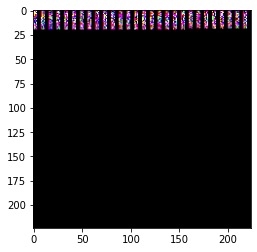

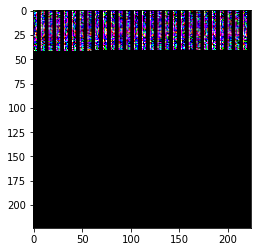

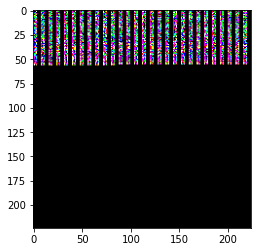

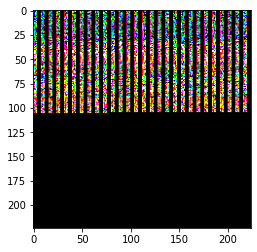

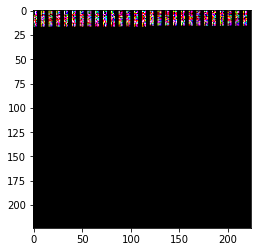

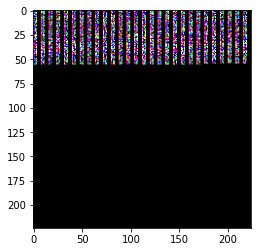

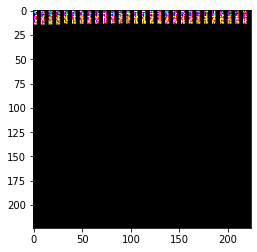

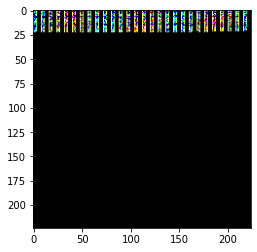

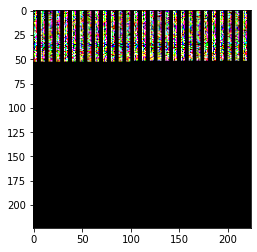

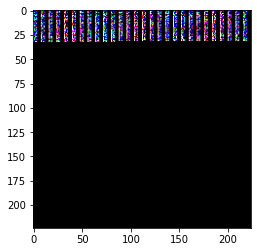

In [ ]:
# how much padding have we added? (i.e. how much space is there in every sample to add more features into?)
import matplotlib.pyplot as plt

for i in range(10):
  plt.figure()
  plt.imshow(dataset_full[i][1].permute(1, 2, 0))
  plt.plot()

## Learning to mould the inputs into a desired shape 

(applied to genreClassificationDataset after)

In [ ]:
# # extract features from .h5 file
# h5 = tables.open_file("data/Jazz/TRAADHS12903CE70A9.h5", mode='r')
# segments_timbre = hdf5_getters.get_segments_timbre(h5)
# h5.close()

In [ ]:
# print(type(segments_timbre[0][0]))
# segments_timbre_tensor = torch.tensor(segments_timbre)
# print(segments_timbre_tensor)
# print(segments_timbre_tensor.size())

In [ ]:
# # finding the maximum size of each dimension of segments_timbre
# max_size_dim1 = 0
# max_size_dim2 = 0
# for i in range(len(dataset_full)):
#   if dataset_full[i][1].size()[0] > max_size_dim1:
#     max_size_dim1 = dataset_full[i][1].size()[0]
#   if dataset_full[i][1].size()[1] > max_size_dim2:
#     max_size_dim2 = dataset_full[i][1].size()[1]
# [max_size_dim1, max_size_dim2]

# # For every sample's segments_timbre array, need 3691 items with 12 elements each

In [ ]:
# len(segments_timbre), max_size_dim1 - len(segments_timbre)

In [ ]:
# # padding segments_timbre feature of data/Jazz/TRAADHS12903CE70A9.h5 to max. dimensions of [3691, 12]

# segments_timbre_tensor_padded = segments_timbre_tensor
# for i in range(max_size_dim1 - len(segments_timbre)):
#   segments_timbre_tensor_padded = torch.cat((segments_timbre_tensor_padded, torch.zeros(1,12)))
# print(segments_timbre_tensor_padded)
# print(segments_timbre_tensor_padded.size())

In [ ]:
# # adding a third dimension to segments_timbre_tensor_padded. 
# # This will have two more copies of segments_timbre_tensor_padded, until we find other things to fill it with.

# temp = torch.unsqueeze(segments_timbre_tensor_padded, 0)
# print(temp.size() == torch.Size([1, max_size_dim1, max_size_dim2]))

# st_padded_cloned = torch.cat((temp, temp))
# print(st_padded_cloned.size() == torch.Size([2, max_size_dim1, max_size_dim2]))

# st_padded_cloned = torch.cat((st_padded_cloned, temp))
# print(st_padded_cloned.size() == torch.Size([3, max_size_dim1, max_size_dim2]))


In [ ]:
# # adding the last (outermost) dimension to st_padded_cloned.

# st_padded_cloned = torch.unsqueeze(st_padded_cloned, 0)
# print(st_padded_cloned.size() == torch.Size([1, 3, max_size_dim1, max_size_dim2]))

## ML Model Training and Testing 

ASSIGNMENT 2 STUFF

In [ ]:
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(2048)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)

In [ ]:
# Lecture notebook parameters (Batch size of 4 with shuffling)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

In [ ]:
# Commented out cause we have our own model
# model = models.resnet18(pretrained=True)

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=8, bias=True)

In [ ]:
# Ensure hardware acceleration: GPU is enabled
device = torch.device('cuda:0')
model = model.to(device)

In [ ]:
# ASSIGNMENT 2 CODE, UNMODIFIED

# # specifying a loss function
# criterion = nn.CrossEntropyLoss()

# # Function to evaluate current model on the test set:
# # a - copies samples and labels to GPU
# # b - apply model to make predictions
# # c - compute the loss between those predictions and the correct labels
# # Notes above based on "transfer_learning.ipynb"

# def run_test(model):
#   nsamples_test = len(dataset_test)
#   loss, correct = 0, 0
#   model.eval()
#   with torch.no_grad():
#     for samples, labels in loader_test:
#       # a
#       samples = samples.to(device)
#       labels = labels.to(device)
#       # b
#       outs = model(samples)
#       # c
#       loss += criterion(outs, labels)
#       # computing output accuracy
#       _, preds = torch.max(outs.detach(), 1)
#       correct_mask = preds == labels
#       correct += correct_mask.sum(0).item()
#   return loss /  nsamples_test, correct / nsamples_test

# # model.eval() and torch.no_grad() put the model in testing mode (some layer
# # behave differently while testing compared to training. )
################################################################################

criterion = nn.CrossEntropyLoss()

def run_test(model):
    nsamples_test = len(dataset_test)
    loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for labels, sample in loader_test:
            labels = labels.to(device)
            # print(labels.size())
            sample = sample.to(device)
            # print(sample.size())
            outs = model(sample)

            loss += criterion(outs, labels)

            _, preds = torch.max(outs.detach(), 1)
            correct_mask = preds == labels
            correct += correct_mask.sum(0).item()
    return loss / nsamples_test, correct / nsamples_test

In [ ]:
# Using the parameters from the class notebook (-0.1 learning rate / 5 epochs)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# ASSIGNMENT 2 CODE, UNMODIFIED

# # function to train model
# # a - copies samples and labels to GPU
# # b - apply model to make predictions
# # c - compute the loss between those predictions and the correct labels
# # Notes above based on "transfer_learning.ipynb"
# def run_train(model, opt, sched):
#   nsamples_train = len(dataset_train)
#   loss_sofar, correct_sofar = 0, 0
#   model.train()
#   with torch.enable_grad():
#     for samples, labels in loader_train:
#       # a 
#       samples = samples.to(device)
#       labels = labels.to(device)
#       # b
#       opt.zero_grad()             # model adjustment
#       outs = model(samples)
#       # c
#       _, preds = torch.max(outs.detach(), 1)
#       loss = criterion(outs, labels)
#       loss.backward()             # model adjustment
#       opt.step()                  # model adjustment
#       # computing output accuracy
#       loss_sofar += loss.item() * samples.size(0)
#       correct_sofar += torch.sum(preds == labels.detach())
#   sched.step()
#   return loss_sofar / nsamples_train, correct_sofar / nsamples_train
################################################################################

def run_train(model, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        for labels, sample in loader_train:
            labels = torch.tensor(labels).to(device)
            sample = sample.to(device)
            opt.zero_grad()
            outs = model(sample)
            _, preds = torch.max(outs.detach(), 1)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * labels.size(0)
            correct_sofar += torch.sum(preds == labels.detach())
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

In [ ]:
def run_all(model, optimizer, scheduler, n_epochs):
    for epoch in range(n_epochs):
        loss_train, acc_train = run_train(model, optimizer, scheduler)
        loss_test, acc_test = run_test(model)
        print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")

In [ ]:
run_test(model)

(tensor(0.6006, device='cuda:0'), 0.1038961038961039)

In [ ]:
run_all(model, optimizer, scheduler, 30) # 4m 54s for 30 epochs!!! 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0: train loss 2.2270 acc 0.1270, test loss 0.5343 acc 0.1299
epoch 1: train loss 2.0792 acc 0.1107, test loss 0.5340 acc 0.1948
epoch 2: train loss 2.0579 acc 0.1694, test loss 0.5416 acc 0.0909
epoch 3: train loss 2.0476 acc 0.1596, test loss 0.5140 acc 0.2468
epoch 4: train loss 2.0505 acc 0.1726, test loss 0.5378 acc 0.1688
epoch 5: train loss 2.0346 acc 0.1857, test loss 0.5138 acc 0.2468
epoch 6: train loss 1.9596 acc 0.2150, test loss 0.5046 acc 0.1688
epoch 7: train loss 1.9383 acc 0.2443, test loss 0.4969 acc 0.3117
epoch 8: train loss 1.9168 acc 0.2313, test loss 0.5014 acc 0.1948
epoch 9: train loss 1.8808 acc 0.2964, test loss 0.4710 acc 0.2078
epoch 10: train loss 1.8093 acc 0.2997, test loss 0.4849 acc 0.2338
epoch 11: train loss 1.7847 acc 0.2834, test loss 0.4913 acc 0.2468
epoch 12: train loss 1.8063 acc 0.2801, test loss 0.4857 acc 0.2468
epoch 13: train loss 1.7505 acc 0.3420, test loss 0.4856 acc 0.2468
epoch 14: train loss 1.7817 acc 0.2638, test loss 0.4835 a

Training log for varying **batch size**. Learning rate (0.001), gamma (0.1)

---

, step size (5) and momentum (0.9) held constant. 

| Batch Size | Min. Test Loss | Max. Test Acc. | Epochs | Elapsed Time (s) |
|------------|----------------|----------------|--------|------------------|
|     1      |     1.9902     |    0.2468      |   20   |      366         |
|     2      |     0.9207     |    0.2987      |   20   |      248         |
|     3      |     0.6475     |    0.2338      |   20   |      204         |
|     4      |     0.4542     |    0.2468      |   20   |      190         |
|     5      |     0.3681     |    0.3117      |   20   |      174         |
|     6      |     0.3102     |    0.3506      |   20   |      168         |
|     7      |     0.2701     |    0.2208      |   20   |      163         |
|     8      |     0.2389     |    0.3247      |   20   |      153         |
|     16     |     0.1241     |    0.2208      |   20   |      111         |
|     32     |     0.0694     |    0.3377      |   20   |      103         |
|     64     |     0.0464     |    0.2857      |   20   |      103         |
|     128    |     0.0247     |    0.2597      |   20   |      105         |

It looks a batch size of around 32 to 64 results in the best loss values and fastest epochs with 384 samples in the full dataset.

E.g. for a batch size of 48, I got:

| Batch Size | Min. Test Loss | Max. Test Acc. | Epochs | Elapsed Time (s) |
|------------|----------------|----------------|--------|------------------|
|     48     |     0.0489     |    0.3247      |   20   |      101         |

Training log for varying **momentum**. Learning rate (0.001), gamma (0.1), batch size = 48, and step size (5) held constant. 

| Momentum | Min. Test Loss | Max. Test Acc. | Epochs | Elapsed Time (s) |
|------------|----------------|----------------|--------|------------------|
|     0.1      |     0.0715     |    0.3117      |   20   |      103         |
|     0.3      |     0.097     |    0.3636      |   20   |      103         |
|     0.5      |     0.0513     |    0.3896      |   20   |      105         |
|     0.7      |     0.0497     |    0.4156      |   20   |      109         |
|     0.9      |     0.0480     |    0.3766      |   20   |      101         |
|     1.1      |     0.0525     |    0.2468      |   20   |      106         |
|     1.5      |     0.0462     |    0.1299      |   20   |      110         |

It looks a momentum of around 0.7 results in the best loss values and the highest accuracy.


Training log for varying **gamma**. Learning rate (0.001), momentum (0.7), batch size = 48, and step size (5) held constant. 

| Gamma | Min. Test Loss | Max. Test Acc. | Epochs | Elapsed Time (s) |
|------------|----------------|----------------|--------|------------------|
|     0.05      |     0.0588     |    0.2857      |   20   |      107         |
|     0.1      |     0.0635     |    0.3247      |   20   |      113         |
|     0.2      |     0.0739     |    0.3377      |   20   |      102         |
|     0.3      |     0.1024     |    0.3117      |   20   |      103         |
|     0.4      |     0.1175     |    0.3117      |   20   |      116         |
|     0.5      |     0.1581     |    0.2987      |   20   |      105         |
|     1.0      |     0.1526     |    0.3117      |   20   |      103         |

It looks a gamma from 0.1 to 0.2 results in the highest accuracy, yet the lowest gamma produces the lowest test loss.
